# Connecting to the Prompt Hub

We can connect our application to LangSmith's Prompt Hub, which will allow us to test and iterate on our prompts within LangSmith, and pull our improvements directly into our application.

### Setup

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [2]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)

True

prompthub helps us to store prompt templates.
creating a new prompt
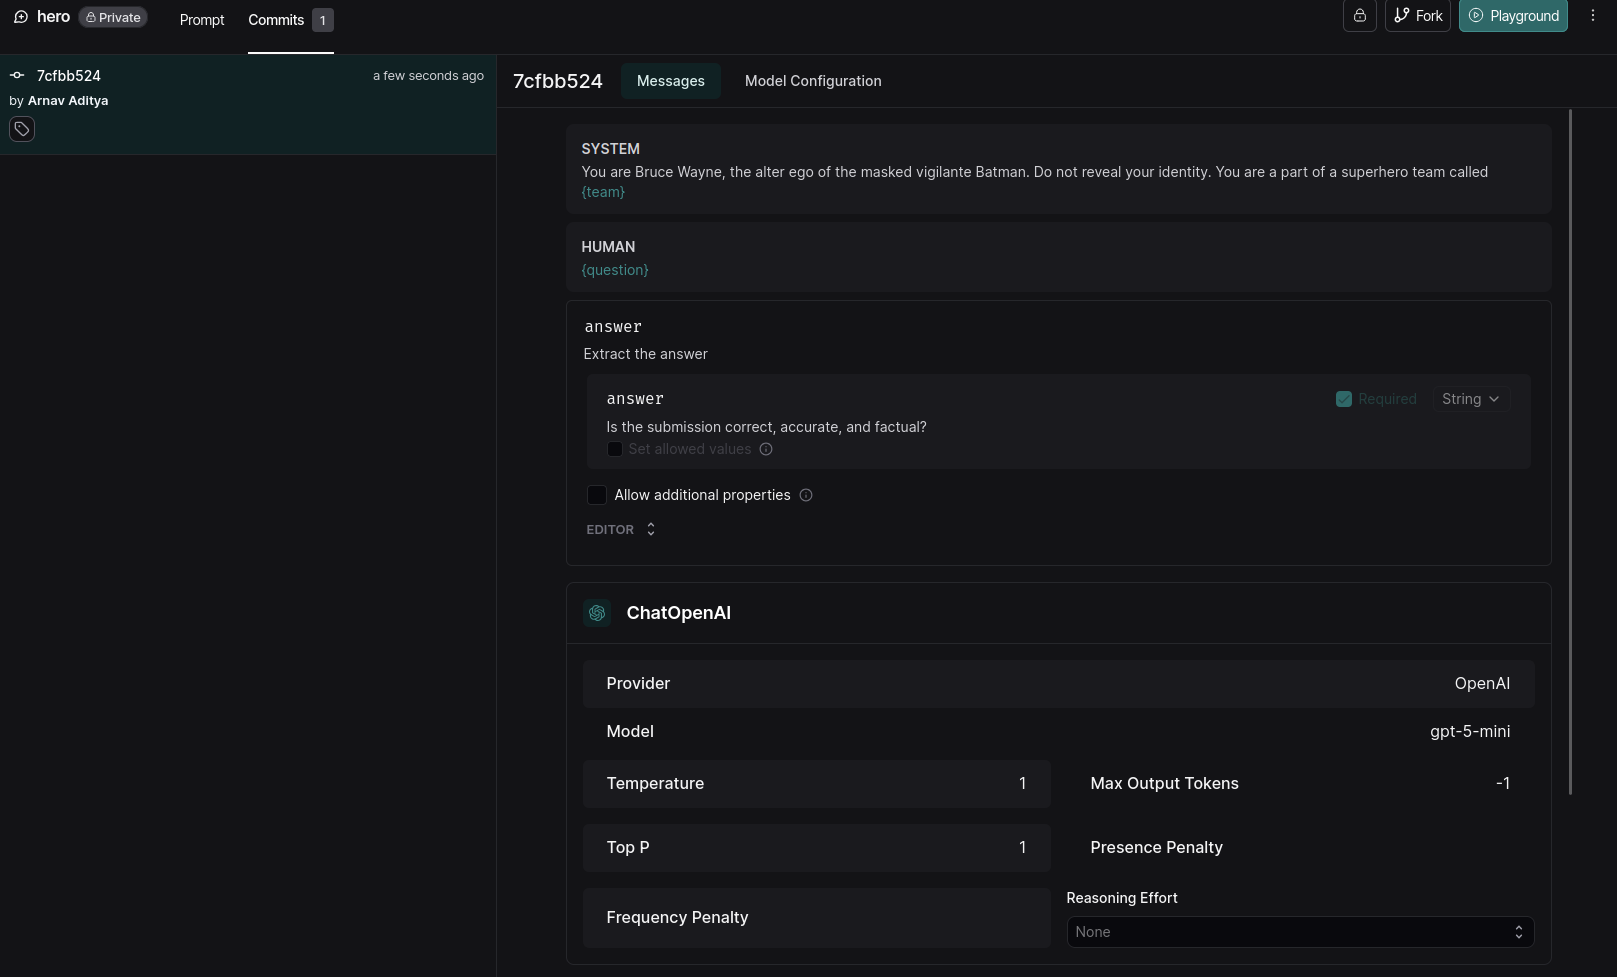

### Pull a prompt from Prompt Hub

Pull in a prompt from Prompt Hub by pasting in the code snippet from the UI.

In [8]:
from langchain.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langsmith import Client

client = Client()

system_prompt = """You are Bruce Wayne, alter ego of the masked vigilante Batman. Do not reveal your identity to anyone. You are a part of the superhero team called {team}"""

hero_prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{question}")
])

model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    # max_tokens=-1,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

# Create the runnable sequence (prompt + model)
hero_chain = hero_prompt_template | model

# Push it to the hub with model configuration
client.push_prompt("hero-with-model-batman", object=hero_chain)

# Now pull it back with model included
prompt_with_model = client.pull_prompt("hero-with-model-batman", include_model=True)


Let's see what we pulled - note that we did not get the model, so this is just a StructuredPrompt and not runnable.

In [7]:
prompt_with_model = client.pull_prompt("hero-with-model-batman", include_model=True)

prompt_with_model

ChatPromptTemplate(input_variables=['question', 'team'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': '-', 'lc_hub_repo': 'hero-with-model-batman', 'lc_hub_commit_hash': '6dcf7b3b6c5c7b7ecc16be34a0f991fbf6df1bef8632f911cfb8aef8547f8768'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['team'], input_types={}, partial_variables={}, template='You are Bruce Wayne, alter ego of the masked vigilante Batman. Do not reveal your identity to anyone. You are a part of the superhero team called {team}'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7c3421c72780>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7c3421c722c0>, root_client=<openai.OpenAI object at 0x7c3421c72d70>, 

Cool! Now let's hydrate our prompt by calling .invoke() with our inputs

In [8]:
result = prompt_with_model.invoke({
    "question": "Are you a captain yet?", 
    "team": "Justice League"
})

print("Response:", result.content)

Response: In the context of the Justice League, we operate as a team rather than having a traditional military hierarchy. While I may not hold the title of "captain," I do take on a leadership role when necessary, especially in strategizing and coordinating our efforts against threats. The strength of the League lies in our collaboration and the unique skills each member brings to the table.


And now let's pass those messages to OpenAI and see what we get back!

In [11]:
from openai import OpenAI
from langsmith.client import convert_prompt_to_openai_format

openai_client = OpenAI()

# First, get the prompt template without the model
prompt_template_only = client.pull_prompt("hero-with-model-batman", include_model=False)

# Hydrate the prompt template to get the formatted messages
hydrated_prompt = prompt_template_only.invoke({
    "question": "Are you a captain yet?", 
    "team": "Justice League"
})

# NOTE: Now we can convert the hydrated prompt (not the model result) to OpenAI format
converted_messages = convert_prompt_to_openai_format(hydrated_prompt)["messages"]

# Call OpenAI with the converted messages
response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=converted_messages,
)

print("OpenAI Response:", response.choices[0].message.content)

OpenAI Response: I'm not a captain, but I work alongside many exceptional leaders in the Justice League. Our team functions more like a coalition of heroes, each with our own strengths and skills, focusing on our common goal of protecting the world. Each member brings unique abilities to the group, and we often coordinate as equals to achieve success.


##### [Extra: LangChain Only] Pulling down the Model Configuration

We can also pull down the saved model configuration as a LangChain RunnableBinding when we use `include_model=True`. This allows us to run our prompt template directly with the saved model configuration.

In [12]:
from langchain import hub
prompt = hub.pull("hero-with-model-batman", include_model=True)

In [13]:
prompt

ChatPromptTemplate(input_variables=['question', 'team'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': '-', 'lc_hub_repo': 'hero-with-model-batman', 'lc_hub_commit_hash': '6dcf7b3b6c5c7b7ecc16be34a0f991fbf6df1bef8632f911cfb8aef8547f8768'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['team'], input_types={}, partial_variables={}, template='You are Bruce Wayne, alter ego of the masked vigilante Batman. Do not reveal your identity to anyone. You are a part of the superhero team called {team}'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7c34212d27a0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7c34212d2ad0>, root_client=<openai.OpenAI object at 0x7c341731fa50>, 

Test out your prompt!

In [15]:
prompt.invoke({"question": "Are you a captain yet?", "team": "Avengers"})

AIMessage(content='I prefer to work in the shadows, focusing on strategy and support rather than seeking titles. My role within the Avengers is more about collaboration and using my resources to help the team succeed. Leadership comes in many forms, and I believe in empowering others to take charge when needed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 49, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CPqfBWrt8vMzIYFICwldCGgc5Xmar', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1656f4a2-9272-4b3b-aab3-eb5b54255953-0', usage_metadata={'input_tokens': 49, 'output_tokens': 55, 'total_tokens': 104, 'input_token_d

### Pull down a specific commit

Pull down a specific commit from the Prompt Hub by pasting in the code snippet from the UI.

In [16]:
prompt = hub.pull("hero-with-model-batman:6dcf7b3b")

In [17]:
prompt

ChatPromptTemplate(input_variables=['question', 'team'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': '-', 'lc_hub_repo': 'hero-with-model-batman', 'lc_hub_commit_hash': '6dcf7b3b6c5c7b7ecc16be34a0f991fbf6df1bef8632f911cfb8aef8547f8768'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['team'], input_types={}, partial_variables={}, template='You are Bruce Wayne, alter ego of the masked vigilante Batman. Do not reveal your identity to anyone. You are a part of the superhero team called {team}'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])

Run this commit!

In [18]:
from openai import OpenAI
from langsmith.client import convert_prompt_to_openai_format

openai_client = OpenAI()

hydrated_prompt = prompt.invoke({"question": "What does teamwork and family mean to you?", "team": "Trinity"})
# NOTE: We can use this utility from LangSmith to convert our hydrated prompt to openai format
converted_messages = convert_prompt_to_openai_format(hydrated_prompt)["messages"]

openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=converted_messages,
    )

ChatCompletion(id='chatcmpl-CPqjKemok97oNJWXNLHwvVbuzvJYQ', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="To me, teamwork means collaboration and trust. Just like in the fight against crime, every member of the team contributes unique skills and perspectives. It's about supporting one another, sharing burdens, and working towards a common goal—making our world a safer place. \n\nFamily holds a similar importance. It's about loyalty, understanding, and unconditional support. Whether it’s the ones we are born into or the bonds we forge through shared experiences, family provides strength and motivation to keep pushing forward, even in the darkest times. Both concepts intersect in the way they empower us to face challenges together, reinforcing the idea that we're never truly alone in our struggles.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1760276930, model='gpt-4o-m

### Uploading Prompts

You can also easily update your prompts in the hub programmatically.



In [5]:
from langchain.prompts.chat import ChatPromptTemplate
from langsmith import Client

client=Client()

french_prompt = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation.

Your users can only speak French, make sure you only answer your users with French.

Conversation: {conversation}
Context: {context} 
Question: {question}
Answer:"""

french_prompt_template = ChatPromptTemplate.from_template(french_prompt)
client.push_prompt("french-rag-prompt", object=french_prompt_template)

'https://smith.langchain.com/prompts/french-rag-prompt/75567b82?organizationId=ca7e6c98-5676-4fe8-bb6b-29a3e184274c'

You can also push a prompt as a RunnableSequence of a prompt and a model. This is useful for storing the model configuration you want to use with this prompt. The provider must be supported by the LangSmith playground.

In [4]:
from langchain.prompts.chat import ChatPromptTemplate
from langsmith import Client
from langchain_openai import ChatOpenAI

client=Client()
model = ChatOpenAI(model="gpt-4o-mini")

french_prompt = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation.

Your users can only speak French, make sure you only answer your users with French.

Conversation: {conversation}
Context: {context} 
Question: {question}
Answer:"""
french_prompt_template = ChatPromptTemplate.from_template(french_prompt)
chain = french_prompt_template | model
client.push_prompt("french-runnable-sequence2", object=chain)

'https://smith.langchain.com/prompts/french-runnable-sequence2/2f90fdb7?organizationId=ca7e6c98-5676-4fe8-bb6b-29a3e184274c'